# Influence of salt intake behavior to blood pressure
## STATS 506 group project
### Author: Xinjun Li

This is a report generated by jupyter notebook for the group project of STATS 506 in University of Michigan.

Our project aims to answer the following question:

>**Is salt intake associated with blood pressure?**
**If so, to what extent is that relationship mediated or moderated by age or waist size?**

We will use [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx) data in analysis.

Required software and packages to run the code are as follows:
* Python3 
* os
* pandas
* numpy
* scipy
* statsmodels
* patsy
* matplotlib

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import patsy
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
import matplotlib.pyplot as plt

In [5]:
# Set working directory
os.chdir('D:/学习/密歇根/STAT506/Group project/stats506/')

# read data
demo_ = pd.read_excel("RawData/Demographics_15_16.xlsx")
BMI_ = pd.read_excel("RawData/Body_measures_2015_16.xlsx")
bp_ = pd.read_excel('RawData/Blood_Pressure_2015_16.xlsx')
nutr_ = pd.read_excel("RawData/Dietary_nutrients_firstday_2015_16.xlsx")

In [8]:
demo=demo_
BMI=BMI_
bp=bp_
nutr=nutr_

### Data cleaning

We need first clean the raw data and join different dataset.

In [9]:
# select useful columns
demo=demo.set_index('SEQN'
                    ).filter(items=['RIDAGEYR']
                    ).dropna()

BMI=BMI.set_index('SEQN'
                  ).filter(items=['BMXWAIST']
                  ).dropna()
nutr=nutr.set_index('SEQN'
                    ).filter(items=['DBD100']
                    ).dropna(
                    ).query('DBD100 != 9'
                    ).astype('category')

# Calculate mean of blood pressure
bp=bp.set_index('SEQN'
                ).filter(regex='(BPXSY*)|(BPXDI*)')
bp=bp.assign(SY=bp.filter(regex='BPXSY*').mean(axis=1, skipna = True),
             DI=bp.filter(regex='BPXDI*').mean(axis=1, skipna = True)
             ).filter(items=['SY','DI']).dropna()

# Merge all data set
df=bp.join(demo,how='inner').join(BMI,how='inner').join(nutr,how='inner')

Take a look at the data we are about to work on.

In [10]:
# Show data summary of numeric variables
print(df.describe())

                SY           DI     RIDAGEYR     BMXWAIST
count  4670.000000  4670.000000  4670.000000  4670.000000
mean    119.510921    66.050393    38.107281    93.630557
std      17.292694    13.378804    21.598139    19.019918
min      74.000000     0.000000     8.000000    46.300000
25%     107.333333    58.666667    18.000000    79.700000
50%     116.666667    66.666667    35.000000    93.000000
75%     128.000000    74.666667    56.000000   105.900000
max     206.666667   124.000000    80.000000   171.600000


Generate plots show the relationship between salt intake behaviors and blood presure.

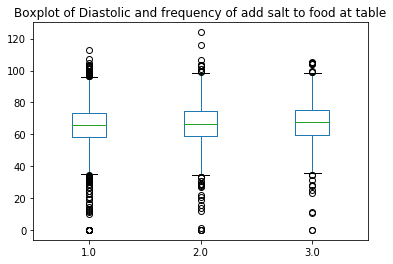

In [11]:
# plot Diastolic and salt intakes
DI_salt=df[['DBD100','DI']
            ].pivot(columns='DBD100', values='DI'
            )
#DI_salt.columns=["Rarely","Occasionally","Very often"]
DI_salt.boxplot(grid=False)
plt.title("Boxplot of Diastolic and frequency of add salt to food at table")
plt.suptitle("")
plt.show()

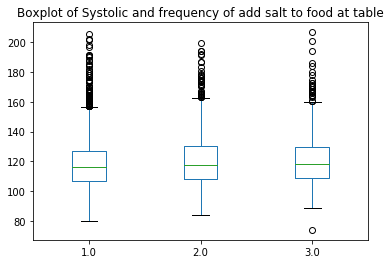

In [12]:
# plot Systolic and salt intakes
SY_salt=df[['DBD100','SY']
            ].pivot(columns='DBD100', values='SY'
            )
#SY_salt.columns=["Rarely","Occasionally","Very often"]
SY_salt.boxplot(grid=False)
plt.title("Boxplot of Systolic and frequency of add salt to food at table")
plt.suptitle("")
plt.show()

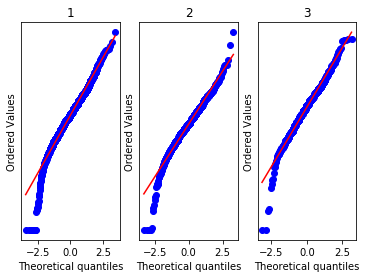

In [15]:
# Test normality of Diastolic given salt intake
DI_salt.columns=["Rarely","Occasionally","Very often"]
SY_salt.columns=["Rarely","Occasionally","Very often"]

ax1 = plt.subplot(131)
a=DI_salt[['Rarely']].dropna().to_numpy()
a=np.reshape(a,(len(a)))
qqplot = stats.probplot(a, plot=plt)
plt.yticks([])

ax2 = plt.subplot(132)
b=DI_salt[['Occasionally']].dropna().to_numpy()
b=np.reshape(b,(len(b)))
qqplot = stats.probplot(b, plot=plt)
plt.yticks([])

ax3 = plt.subplot(133)
c=DI_salt[['Very often']].dropna().to_numpy()
c=np.reshape(c,(len(c)))
qqplot = stats.probplot(c, plot=plt)
plt.yticks([])

ax1.set_title('1')
ax2.set_title('2')
ax3.set_title('3')

plt.show()

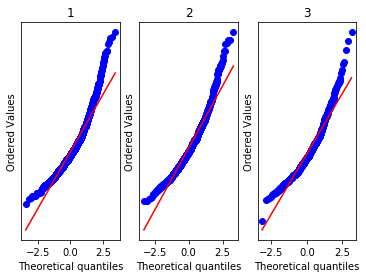

In [17]:
# Test normality of Systolic given salt intake
ax1 = plt.subplot(131)
a=SY_salt[['Rarely']].dropna().to_numpy()
a=np.reshape(a,(len(a)))
qqplot = stats.probplot(a, plot=plt)
plt.yticks([])

ax2 = plt.subplot(132)
b=SY_salt[['Occasionally']].dropna().to_numpy()
b=np.reshape(b,(len(b)))
qqplot = stats.probplot(b, plot=plt)
plt.yticks([])

ax3 = plt.subplot(133)
c=SY_salt[['Very often']].dropna().to_numpy()
c=np.reshape(c,(len(c)))
qqplot = stats.probplot(c, plot=plt)
plt.yticks([])

ax1.set_title('1')
ax2.set_title('2')
ax3.set_title('3')

plt.show()

### Fit OLS

Now fit the ordinary least square to the data.
The models used are:
`DI ~ DBD100` and `SY ~ DBD100`

#### Diastolic result

In [10]:
# fit ols to Diastolic measurements
ols_DI=ols('DI~DBD100',data=df).fit()
# Print the summary
print(ols_DI.summary())

                            OLS Regression Results                            
Dep. Variable:                     DI   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.993
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           0.000343
Time:                        17:45:18   Log-Likelihood:                -18730.
No. Observations:                4670   AIC:                         3.747e+04
Df Residuals:                    4667   BIC:                         3.749e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        65.4003      0.270    242.026

In [5]:
# Show data summary of categorical variables
print(df.describe(include='category'))

        DBD100
count   4670.0
unique     3.0
top        1.0
freq    2444.0


In [11]:
print(anova_lm(ols_DI))

              df        sum_sq      mean_sq         F    PR(>F)
DBD100       2.0    2852.76590  1426.382950  7.992829  0.000343
Residual  4667.0  832862.70838   178.457833       NaN       NaN


#### Systolic result

In [12]:
# fit ols to Systolic measurements
ols_SY=ols('SY~DBD100',data=df).fit()
# Print the summary
print(ols_SY.summary())

                            OLS Regression Results                            
Dep. Variable:                     SY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.841
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           0.000147
Time:                        17:45:18   Log-Likelihood:                -19928.
No. Observations:                4670   AIC:                         3.986e+04
Df Residuals:                    4667   BIC:                         3.988e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       118.5461      0.349    339.471

In [13]:
print(anova_lm(ols_SY))

              df        sum_sq      mean_sq         F    PR(>F)
DBD100       2.0  5.269709e+03  2634.854509  8.840718  0.000147
Residual  4667.0  1.390935e+06   298.036262       NaN       NaN


From the above results, we know that both models are significant and every coefficients are significant(at the level of 95%).

### Moderation effect of waist size


First, add two columns recording a standiviation above and below  of waist size.

In [14]:
df['waist_sd'] = df['BMXWAIST'].std()
df['waist_up']=df['BMXWAIST']+df['waist_sd']
df['waist_down']=df['BMXWAIST']-df['waist_sd']

#### Diastolic result

Fit model: `DI ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST`

In [15]:
moderation_DI = ols('DI ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST', data=df).fit()
print(moderation_DI.summary())

                            OLS Regression Results                            
Dep. Variable:                     DI   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     92.35
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           5.66e-93
Time:                        17:45:18   Log-Likelihood:                -18518.
No. Observations:                4670   AIC:                         3.705e+04
Df Residuals:                    4664   BIC:                         3.709e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 45

In [16]:
print(anova_lm(moderation_DI))

                     df         sum_sq       mean_sq           F        PR(>F)
DBD100              2.0    2852.765900   1426.382950    8.748537  1.613124e-04
BMXWAIST            1.0   72202.692290  72202.692290  442.845941  5.372836e-94
DBD100:BMXWAIST     2.0     229.976156    114.988078    0.705265  4.940305e-01
Residual         4664.0  760430.039934    163.042461         NaN           NaN


In [17]:
# one standard deviation above mean
moderation_DI_up = ols('DI ~ DBD100 + waist_up + DBD100 * waist_up', data=df).fit()
print(moderation_DI_up.summary())

                            OLS Regression Results                            
Dep. Variable:                     DI   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     92.35
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           5.66e-93
Time:                        17:45:18   Log-Likelihood:                -18518.
No. Observations:                4670   AIC:                         3.705e+04
Df Residuals:                    4664   BIC:                         3.709e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 41

In [18]:
# one standard deviation below mean
moderation_DI_down = ols('DI ~ DBD100 + waist_down + DBD100 * waist_down', data=df).fit()
print(moderation_DI_down.summary())

                            OLS Regression Results                            
Dep. Variable:                     DI   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     92.35
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           5.66e-93
Time:                        17:45:18   Log-Likelihood:                -18518.
No. Observations:                4670   AIC:                         3.705e+04
Df Residuals:                    4664   BIC:                         3.709e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

For the models above, coefficients for the interaction terms and salt intake itself are not significant(at level of 95%).
There are not moderation effect of waist size on salt intake and diastole.

#### Systolic result

Fit model: `SY ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST`

In [19]:
moderation_SY = ols('SY ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST', data=df).fit()
print(moderation_SY.summary())

                            OLS Regression Results                            
Dep. Variable:                     SY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     199.6
Date:                Tue, 10 Dec 2019   Prob (F-statistic):          2.71e-193
Time:                        17:45:18   Log-Likelihood:                -19484.
No. Observations:                4670   AIC:                         3.898e+04
Df Residuals:                    4664   BIC:                         3.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 83

In [20]:
print(anova_lm(moderation_SY))

                     df        sum_sq        mean_sq           F  \
DBD100              2.0  5.269709e+03    2634.854509   10.684907   
BMXWAIST            1.0  2.407964e+05  240796.362719  976.481519   
DBD100:BMXWAIST     2.0  1.548005e+01       7.740026    0.031387   
Residual         4664.0  1.150123e+06     246.595924         NaN   

                        PR(>F)  
DBD100            2.345321e-05  
BMXWAIST         8.385065e-195  
DBD100:BMXWAIST   9.691002e-01  
Residual                   NaN  


In [21]:
# one standard deviation above mean
moderation_SY_up = ols('SY ~ DBD100 + waist_up + DBD100 * waist_up', data=df).fit()
print(moderation_SY_up.summary())

                            OLS Regression Results                            
Dep. Variable:                     SY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     199.6
Date:                Tue, 10 Dec 2019   Prob (F-statistic):          2.71e-193
Time:                        17:45:19   Log-Likelihood:                -19484.
No. Observations:                4670   AIC:                         3.898e+04
Df Residuals:                    4664   BIC:                         3.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 76

In [22]:
# one standard deviation below mean
moderation_SY_down = ols('SY ~ DBD100 + waist_down + DBD100 * waist_down', data=df).fit()
print(moderation_SY_down.summary())

                            OLS Regression Results                            
Dep. Variable:                     SY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     199.6
Date:                Tue, 10 Dec 2019   Prob (F-statistic):          2.71e-193
Time:                        17:45:19   Log-Likelihood:                -19484.
No. Observations:                4670   AIC:                         3.898e+04
Df Residuals:                    4664   BIC:                         3.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

For the models above, coefficients for the interation terms and salt intake itself are not significant(at level of 95%). 
There are not moderation effect of waist size on salt intake and diastole.

### Mediation effect of age

Fit model: `RIDAGEYR ~ DBD100` to see if there are relationships between age and salt intake

In [23]:
# test if there is relationship between age and salt intake.
age_D = ols('RIDAGEYR ~ DBD100', data=df).fit()
print(age_D.summary())

                            OLS Regression Results                            
Dep. Variable:               RIDAGEYR   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     20.96
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           8.67e-10
Time:                        17:45:19   Log-Likelihood:                -20954.
No. Observations:                4670   AIC:                         4.191e+04
Df Residuals:                    4667   BIC:                         4.193e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        36.2901      0.435     83.420

The model is significant. There are relationships between age and salt intake behavior.

#### Diastolic result

Fit model: `DI ~ DBD100 + RIDAGEYR`.

In [24]:
mediation_DI = ols('DI ~ DBD100 + RIDAGEYR', data=df).fit()
print(mediation_DI.summary())

                            OLS Regression Results                            
Dep. Variable:                     DI   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     121.6
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           7.67e-76
Time:                        17:45:19   Log-Likelihood:                -18563.
No. Observations:                4670   AIC:                         3.713e+04
Df Residuals:                    4666   BIC:                         3.716e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        59.4642      0.411    144.512

In [28]:
print(anova_lm(mediation_DI))

              df         sum_sq       mean_sq           F        PR(>F)
DBD100       2.0    2852.765900   1426.382950    8.586573  1.895590e-04
RIDAGEYR     1.0   57756.868745  57756.868745  347.686130  6.716480e-75
Residual  4666.0  775105.839635    166.117840         NaN           NaN


The model is significant. Age might be a mediator between salt intake and diastolic.

In [25]:
# Create design matrix
DI,model_mat = patsy.dmatrices("DI ~ DBD100 + RIDAGEYR", data=df)
df_med_DI=pd.DataFrame(model_mat).iloc[:,1:]
df_med_DI.columns=['DBD2','DBD3','RIDAGEYR']
df_med_DI['DI']=DI

# origin model and mediator model
med_model_DI=sm.OLS.from_formula('DI ~ RIDAGEYR+DBD2+DBD3', data=df_med_DI)
mediator_DI=sm.OLS.from_formula('RIDAGEYR ~ DBD2+DBD3', data=df_med_DI)

# origin model and mediator model
med_DI = Mediation(med_model_DI,mediator_DI,['DBD2','DBD3'],'RIDAGEYR').fit()
print(med_DI.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            1.325481        0.882149        1.817338    0.000
ACME (treated)            1.325481        0.882149        1.817338    0.000
ADE (control)             1.689822        0.133945        3.195800    0.038
ADE (treated)             1.689822        0.133945        3.195800    0.038
Total effect              3.015304        1.377978        4.588222    0.002
Prop. mediated (control)  0.439429        0.262442        0.890685    0.002
Prop. mediated (treated)  0.439429        0.262442        0.890685    0.002
ACME (average)            1.325481        0.882149        1.817338    0.000
ADE (average)             1.689822        0.133945        3.195800    0.038
Prop. mediated (average)  0.439429        0.262442        0.890685    0.002


All the mediation effect(ACME) are significant(at level of 95%).
Which means that age is a mediator between salt intake and diastolic.

#### Systolic result

Fit model: `SY ~ DBD100 + RIDAGEYR`.

In [26]:
mediation_SY = ols('SY ~ DBD100 + RIDAGEYR', data=df).fit()
print(mediation_SY.summary())

                            OLS Regression Results                            
Dep. Variable:                     SY   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     753.2
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:49:04   Log-Likelihood:                -19015.
No. Observations:                4670   AIC:                         3.804e+04
Df Residuals:                    4666   BIC:                         3.806e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       101.9719      0.453    224.951

In [28]:
print(anova_lm(mediation_SY))

              df         sum_sq       mean_sq           F        PR(>F)
DBD100       2.0    2852.765900   1426.382950    8.586573  1.895590e-04
RIDAGEYR     1.0   57756.868745  57756.868745  347.686130  6.716480e-75
Residual  4666.0  775105.839635    166.117840         NaN           NaN


The model is significant. 
Even thought the coefficients of salt intake is not significant(at level of 95%).
Age might be a mediator between salt intake and systolic.

In [27]:
# Create design matrix
SY,model_mat = patsy.dmatrices("SY ~ DBD100 + RIDAGEYR", data=df)
df_med_SY=pd.DataFrame(model_mat).iloc[:,1:]
df_med_SY.columns=['DBD2','DBD3','RIDAGEYR']
df_med_SY['SY']=SY

# origin model and mediator model
med_model_SY=sm.OLS.from_formula('SY ~ RIDAGEYR+DBD2+DBD3', data=df_med_SY)
mediator_SY=sm.OLS.from_formula('RIDAGEYR ~ DBD2+DBD3', data=df_med_SY)

# origin model and mediator model
med_SY = Mediation(med_model_SY,mediator_SY,['DBD2','DBD3'],'RIDAGEYR').fit()
print(med_SY.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            3.725348        2.470640        4.927865    0.000
ACME (treated)            3.725348        2.470640        4.927865    0.000
ADE (control)             0.547837       -1.021655        2.148920    0.506
ADE (treated)             0.547837       -1.021655        2.148920    0.506
Total effect              4.273185        2.252254        6.263328    0.000
Prop. mediated (control)  0.878754        0.617803        1.427143    0.000
Prop. mediated (treated)  0.878754        0.617803        1.427143    0.000
ACME (average)            3.725348        2.470640        4.927865    0.000
ADE (average)             0.547837       -1.021655        2.148920    0.506
Prop. mediated (average)  0.878754        0.617803        1.427143    0.000


All the mediation effect(ACME) are significant.
Which means that age is a mediator between salt intake and systolic.

## Summary

From the analysis above, we know that the salt intake behavior have significant influence on people's blood pressure
(both diastolic and systolic).
The influence of salt intake behavior on blood pressure(both diastolic and systolic) is not modirated by waist size.
Age is a Mediator between salt intake behavior and blood pressure(both diastolic and systolic).

## Reference

1. <https://en.wikipedia.org/wiki/Moderation_(statistics)>
2. <http://web.pdx.edu/~newsomj/semclass/ho_mediation.pdf>

## Aknowledgement

I would like to thank Dr. Henderson for always patiently answering any questions.
I would also like to thank my fellow group members, Jingyan Lu and Karthik G. 
Your works are very inspiring. I cannot finishing this report without your contributions.